In [3]:
import sys
import os

os.chdir(os.path.join(sys.path[0], ".."))
import logging

logger = logging.getLogger()
logger.disabled = True

In [4]:
from memory.utils import read_yaml

config = read_yaml("train.yaml")
from memory.model import create_policy_net

# config.pop("seed")
# config.pop("training_params")


net = create_policy_net(
    capacity={"episodic": 128, "semantic": 0},
    policy_type = "episodic_memory_manage",
    function_type = "MLP",
    embedding_dim = 1,
    generator_params=config["generator_params"],
)

net

MLP(
  (embeddings): Embeddings(
    (heads): Embedding(40, 1)
    (relations): Embedding(1, 1)
    (tails): Embedding(30, 1)
    (names): Embedding(20, 1)
    (specials): Embedding(2, 1, padding_idx=0)
    (positional_embeddings): Embedding(129, 3)
  )
  (fc1): Linear(in_features=387, out_features=387, bias=True)
  (fc2): Linear(in_features=387, out_features=129, bias=True)
  (fc3): Linear(in_features=387, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
)

In [6]:
net.embeddings.specials.weight.requires_grad

True

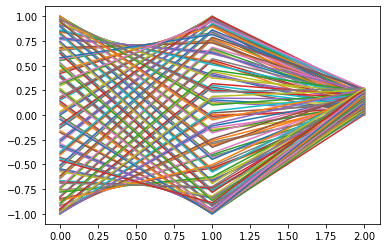

In [39]:
import matplotlib.pyplot as plt

for foo in net.embeddings.positional_embeddings.weight:
    plt.plot(foo)

In [ ]:
# Code is heavily inspired by Morvan Zhou's code. Please check out
# his work at github.com/MorvanZhou/pytorch-A3C
import gym
import torch as T
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class SharedAdam(T.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
            weight_decay=0):
        super(SharedAdam, self).__init__(params, lr=lr, betas=betas, eps=eps,
                weight_decay=weight_decay)

        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['exp_avg'] = T.zeros_like(p.data)
                state['exp_avg_sq'] = T.zeros_like(p.data)

                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

class ActorCritic(nn.Module):
    def __init__(self, input_dims, n_actions, gamma=0.99):
        super(ActorCritic, self).__init__()

        self.gamma = gamma

        self.pi1 = nn.Linear(*input_dims, 128)
        self.v1 = nn.Linear(*input_dims, 128)
        self.pi = nn.Linear(128, n_actions)
        self.v = nn.Linear(128, 1)

        self.rewards = []
        self.actions = []
        self.states = []

    def remember(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def forward(self, state):
        pi1 = F.relu(self.pi1(state))
        v1 = F.relu(self.v1(state))

        pi = self.pi(pi1)
        v = self.v(v1)

        return pi, v

    def calc_R(self, done):
        states = T.tensor(self.states, dtype=T.float)
        _, v = self.forward(states)

        R = v[-1]*(1-int(done))

        batch_return = []
        for reward in self.rewards[::-1]:
            R = reward + self.gamma*R
            batch_return.append(R)
        batch_return.reverse()
        batch_return = T.tensor(batch_return, dtype=T.float)

        return batch_return

    def calc_loss(self, done):
        states = T.tensor(self.states, dtype=T.float)
        actions = T.tensor(self.actions, dtype=T.float)

        returns = self.calc_R(done)

        pi, values = self.forward(states)
        values = values.squeeze()
        critic_loss = (returns-values)**2

        probs = T.softmax(pi, dim=1)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        actor_loss = -log_probs*(returns-values)

        total_loss = (critic_loss + actor_loss).mean()
    
        return total_loss

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float)
        pi, v = self.forward(state)
        probs = T.softmax(pi, dim=1)
        dist = Categorical(probs)
        action = dist.sample().numpy()[0]

        return action

class Agent(mp.Process):
    def __init__(self, global_actor_critic, optimizer, input_dims, n_actions, 
                gamma, lr, name, global_ep_idx, env_id):
        super(Agent, self).__init__()
        self.local_actor_critic = ActorCritic(input_dims, n_actions, gamma)
        self.global_actor_critic = global_actor_critic
        self.name = 'w%02i' % name
        self.episode_idx = global_ep_idx
        self.env = gym.make(env_id)
        self.optimizer = optimizer

    def run(self):
        t_step = 1
        while self.episode_idx.value < N_GAMES:
            done = False
            observation = self.env.reset()
            score = 0
            self.local_actor_critic.clear_memory()
            while not done:
                action = self.local_actor_critic.choose_action(observation)
                observation_, reward, done, info = self.env.step(action)
                score += reward
                self.local_actor_critic.remember(observation, action, reward)
                if t_step % T_MAX == 0 or done:
                    loss = self.local_actor_critic.calc_loss(done)
                    self.optimizer.zero_grad()
                    loss.backward()
                    for local_param, global_param in zip(
                            self.local_actor_critic.parameters(),
                            self.global_actor_critic.parameters()):
                        global_param._grad = local_param.grad
                    self.optimizer.step()
                    self.local_actor_critic.load_state_dict(
                            self.global_actor_critic.state_dict())
                    self.local_actor_critic.clear_memory()
                t_step += 1
                observation = observation_
            with self.episode_idx.get_lock():
                self.episode_idx.value += 1
            print(self.name, 'episode ', self.episode_idx.value, 'reward %.1f' % score)

if __name__ == '__main__':
    lr = 1e-4
    env_id = 'CartPole-v0'
    n_actions = 2
    input_dims = [4]
    N_GAMES = 3000
    T_MAX = 5
    global_actor_critic = ActorCritic(input_dims, n_actions)
    global_actor_critic.share_memory()
    optim = SharedAdam(global_actor_critic.parameters(), lr=lr, 
                        betas=(0.92, 0.999))
    global_ep = mp.Value('i', 0)

    workers = [Agent(global_actor_critic,
                    optim,
                    input_dims,
                    n_actions,
                    gamma=0.99,
                    lr=lr,
                    name=i,
                    global_ep_idx=global_ep,
                    env_id=env_id) for i in range(mp.cpu_count())]
    [w.start() for w in workers]
    [w.join() for w in workers]




In [ ]:
from memory.model import Embeddings, MLP
from memory.utils import read_yaml

config = read_yaml("./train.yaml")

# embeddings = Embeddings(
#     generator_params=config["generator_params"],
#     embedding_dim=1,
#     num_rows=128,
#     num_cols=3,
# )

model = MLP(
    capacity={"episodic": 128, "semantic": 0},
    policy_type="episodic_memory_manage",
    embedding_dim=4,
    generator_params=config["generator_params"],
)


In [ ]:
from memory import EpisodicMemory

M_e = EpisodicMemory(128)

from memory.environment.gym import MemoryEnv

env = MemoryEnv(**config["generator_params"])
env.reset()

while not M_e.is_kinda_full:
    oq = env.step('foo')[0]
    ob = oq['observation']
    question = oq['question']
    M_e.add(M_e.ob2epi(ob))

# embs = embeddings.episodic2numerics(M_e)


In [ ]:
model(model.make_state(M_e, None, None))

In [ ]:
embeddings.positional_embeddings.weight

In [ ]:
embeddings.eq2numerics(question)

In [ ]:
import torch
torch.cat([torch.tensor([1]),torch.tensor([1]),torch.tensor([1])])

In [ ]:
torch.tensor([1]).shape

In [ ]:
import torch
foo = torch.tensor([1],device='gpu')

foo.is_cuda

In [ ]:
from memory.utils import read_yaml
from memory.environment.gym import MemoryEnv
from reinforcement_q_learning import Transition
from memory.utils import write_json, seed_everything

config = read_yaml("./train.yaml")

In [ ]:
config = read_yaml("./train.yaml")
config

In [ ]:
from dqn_pytorch_example import *

Transition

In [ ]:
from memory.environment.generator import OQAGenerator
gen_params = {
    "max_history": 1024,
    "semantic_knowledge_path": "./data/semantic-knowledge.json",
    "names_path": "./data/top-human-names",
    "weighting_mode": "weighted",
    "commonsense_prob": 0.5,
    "time_start_at": 0,
    "limits": {
        "heads": None,
        "tails": None,
        "names": None,
        "allow_spaces": True,
    },
    "disjoint_entities": True,
}

oqag = OQAGenerator(**gen_params)

len(oqag.heads), len(oqag.tails), len(oqag.names)

In [ ]:
from memory.utils import read_yaml

config = read_yaml('./train.yaml')
config['generator_params']

In [ ]:
from memory.environment.generator import OQAGenerator

oqag  = OQAGenerator()

len(oqag.heads), len(oqag.tails)

In [ ]:
import random
import matplotlib.pyplot as plt
from collections import Counter

foo = [foo for foo in range(0, 1024)]
weights1 = foo
weights2 = [bar ** 2 for bar in foo]

num_to_sample = 10000

samples1 = [
    val / num_to_sample
    for key, val in sorted(
        dict(Counter(random.choices(foo, k=num_to_sample, weights=weights1))).items()
    )
]

samples2 = [val / num_to_sample
    for key, val in sorted(
        dict(Counter(random.choices(foo, k=num_to_sample, weights=weights2))).items()
    )
]


plt.figure()
plt.plot(samples1)
# plt.plot(samples2)


In [ ]:
len(samples1), len(samples2)

In [ ]:
samples2

In [ ]:
Counter(random.choices(foo, k=100, weights=[2*bar for bar in foo]))

In [ ]:
[2*bar for bar in foo]

In [ ]:
foo

In [ ]:
from torch.distributions import Categorical

probs = torch.tensor([1,2,3,4])
m = Categorical(probs)
action = m.sample()

m, action, m.log_prob(torch.tensor(action))

In [ ]:
import torch

bar = torch.tensor([[1]]) + torch.tensor([2])

In [ ]:
bar, bar.shape

In [ ]:
from memory.utils import read_yaml

config = read_yaml("./train.yaml")
from memory.model import Embeddings


embs = Embeddings(
    generator_params=config["generator_params"],
    embedding_dim=4,
    num_rows=129,
    num_cols=6,
)


In [ ]:

import matplotlib.pyplot as plt
plt.figure()

for emb in embs.positional_embeddings.weight:
    plt.plot(emb)

In [ ]:
import torch
import numpy as np
def position_encoding_init(n_position, d_pos_vec):
    ''' Init the sinusoid position encoding table '''

    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2*(i//2) / d_pos_vec) for i in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    return torch.from_numpy(position_enc).type(torch.float32)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()

for row in position_encoding_init(129, 6):
    plt.plot(row)